In [1]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import json
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from IPython.display import display

drive.mount('/content/drive')
diretorio = '/content/drive/MyDrive/Redes Neurais/DATA/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
X_t = np.load(diretorio+'X_train.npy')
y_t = np.load(diretorio+'y_train.npy')

X_v = np.load(diretorio+'X_test.npy')
y_v = np.load(diretorio+'y_test.npy')

X_t.shape, y_t.shape

((8640, 100, 52), (8640, 52))

In [5]:
model = Sequential()

model.add(InputLayer((100, 1)))
model.add(GRU(100))
model.add(Dense(64, 'sigmoid'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,429
Trainable params: 37,429
Non-trainable params: 0
_________________________________________________________________


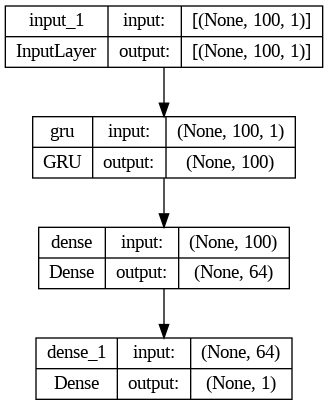

In [6]:
plot_model(model, show_shapes=True)

In [7]:
EPOCHS = 100
batch_size = 64
patience = 20 #no improvement patience

In [8]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
earlystopper = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True, verbose=0)

In [9]:
def plot_series_diff(series1, series2, i=0):
    # Calcula a diferença entre as séries
    diff = series1 - series2
    abs_diff = np.abs(diff)

    # Plota as séries originais
    plt.figure(figsize=(10, 6))
    plt.plot(series1, color='blue', label='Original', linewidth=1)
    plt.plot(series2, color='orange', label='Predicted', linewidth=1)

    # Plota a diferença entre as séries
    plt.plot(diff, color='green', label='Difference')

    # Plota o módulo da diferença entre as séries
    plt.plot(abs_diff, color='red', label='Absolute Difference')

    plt.title(f'Time Series {i+1}')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Redes Neurais/results/GRU/uni/sensor_'+str(i)+'_diff.png')

    plt.show()

In [11]:
path_to_save = '/content/drive/MyDrive/Redes Neurais/results/GRU/uni/sensor_'
try:
    os.remove(path_to_save+".json")
except FileNotFoundError:
    pass

for i in range(len(y_t[0])):
    X_ta = X_t[:,:,i]
    y_ta = y_t[:,i]

    X_va = X_v[:,:,i]
    y_va = y_v[:,i]

    history = model.fit(X_ta, y_ta, batch_size=100, epochs=EPOCHS, callbacks=[earlystopper], validation_data=(X_va, y_va))

    plt.plot(history.history['loss'], label='loss', linewidth=1)
    plt.plot(history.history['val_loss'], label = 'val_loss', linewidth=1)
    plt.xlabel('Epoch')
    plt.ylabel('loss/RME')
    plt.legend(loc='lower right')
    plt.savefig(path_to_save+str(i)+'_loss.png')

    predictions = model.predict(X_va)
    predictions = predictions.flatten()
    predictions.shape

    plot_series_diff(y_va, predictions, i=i)

    final_result = {}
    final_result['Sensor'] = i
    final_result['Model'] = 'GRU-univariate'
    final_result['RME_final'] = history.history['root_mean_squared_error'][-1]
    final_result['RME_val_final'] = history.history['val_root_mean_squared_error'][-1]
    final_result['MSE_final'] = history.history['loss'][-1]
    final_result['MSE_val_final'] = history.history['val_loss'][-1]

    with open(path_to_save+".json", "a") as arquivo:
      json.dump(final_result, arquivo)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 5.3192e-05 - root_mean_squared_error: 0.0073

KeyboardInterrupt: ignored

In [ ]:
from datetime import datetime
import pytz

# Get the current time in Brazil's time zone
brazil_tz = pytz.timezone('America/Sao_Paulo')
current_time = datetime.now(brazil_tz)

# Print the current time
print(current_time)
